# Least Square B-spline Fitting
Control Points.
$$
Q=[Q_0, Q_1, \cdots , Q_n]^T
$$

Samples.
$$
P=[P_0, P_1, \cdots , P_m]^T
$$

Least square error function.
$$
E(Q) =\frac{1}{2}\sum_{k=0}^m \|  \sum_{j=0}^n{N_{j,d}(t_k)Q_j} - P_k \|^2
$$

Calculate partial derivatives of Q to minimize E.
$$
\frac{dE}{dQ_i} = \sum_{k=0}^m  \sum_{j=0}^n{N_{j,d}(t_k)Q_j} - \sum_{k=0}^{m} P_k \\
\sum_{k=0}^m  \sum_{j=0}^n{N_{j,d}(t_k)Q_j} - \sum_{k=0}^{m} P_k = 0 \\
A^T AQ - A^T P = 0
$$

where A is a matrix with $m+1$ rows and $n+1$colums.
$$
A_{i,j} = N_{j,d}(t_i)
$$

$$
Q = (A^TA)^{-1}A^T P
$$

In [52]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib notebook

## Samples

<IPython.core.display.Javascript object>


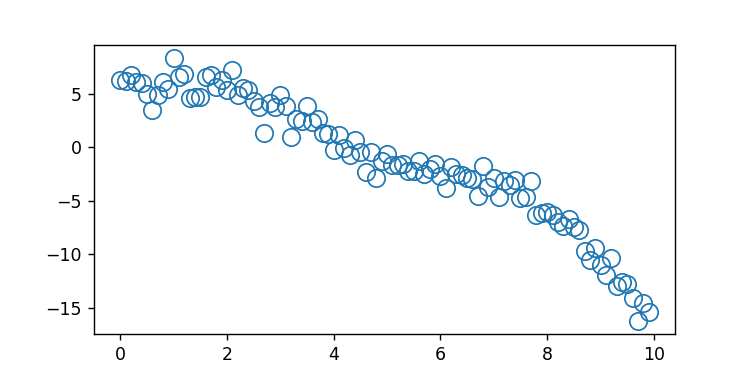

In [53]:
x = np.arange(0, 10, 0.1)
yt = 5 - 0.2 * x**2 + 2 * np.sin(x)
y  = 5 - 0.2 * x**2 + 2 * np.sin(x) + np.random.normal(0.0, 1.0, len(x))

fig = plt.figure("Samples", figsize=(6, 3))
plt.plot(x, y,"o",mfc="none",  ms=10)

## Least Square Fitting

In [54]:
n = 3
X = np.zeros((len(x), n), float)
X[:, 0] = 1 
X[:, 1] = x**2
X[:, 2] = np.sin(x)
(theta, residuals, rank, s) = np.linalg.lstsq(X, y)

C:\ProgramData\Anaconda3\envs\py35con\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


<IPython.core.display.Javascript object>


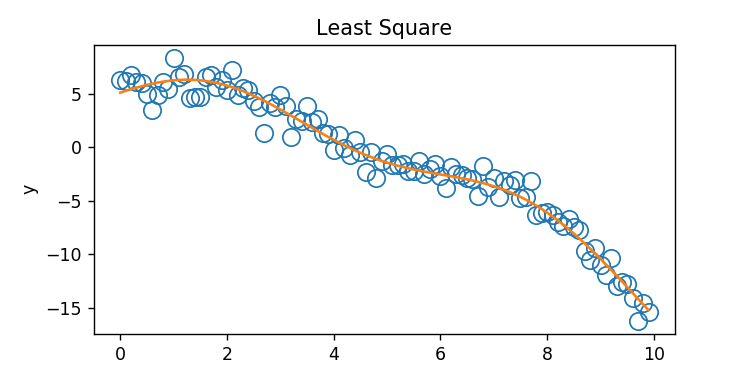

Text(0,0.5,'y')

In [56]:
fig = plt.figure("LS", figsize=(6, 3))
plt.plot(x, y,"o",mfc="none",  ms=10)
plt.plot(x, theta[0] + theta[1] * X[:, 1] + theta[2] * X[:, 2], "-")
# plt.plot(x, yt, "-", c="gray")

plt.title("Least Square")
plt.xlabel("x")
plt.ylabel("y")

## Least Square B-spline Fitting

### Knot vector and basic function

In [57]:
def open_uniform_vector(m, degree):
    u = np.zeros((m, 1), dtype=float)
    j = 1
    for i in range(m):
        if i <= degree: 
            u[i] = 0.0
        elif i < m - (degree+1): 
            u[i] = 1.0 / (m - 2*(degree+1) + 1) * j
            j += 1
        else: 
            u[i] = 1.0 
    return u.flatten()

def basic_function(u, j, k, t):   
    w1 = 0.0
    w2 = 0.0
    if k == 0: 
        if u[j] < t and t <= u[j+1]:
            var = 1.0
        else:
            var = 0.0;
    else:
        if (u[j+k+1]-u[j+1]) != 0:
            w1 = basic_function(u, j+1, k-1, t) * (u[j+k+1] - t) / (u[j+k+1] - u[j+1])
        if (u[j+k]-u[j]) != 0:  
            w2 = basic_function(u, j, k-1, t)   * (t - u[j])     / (u[j+k] - u[j])        
        var = w1 + w2
    return var

### Parameters

In [58]:
n = 8 # num of control points
d = 2 # degree of b-spline
nk = d + n + 1 # num of knot 
m = len(x) # num of data points

<IPython.core.display.Javascript object>


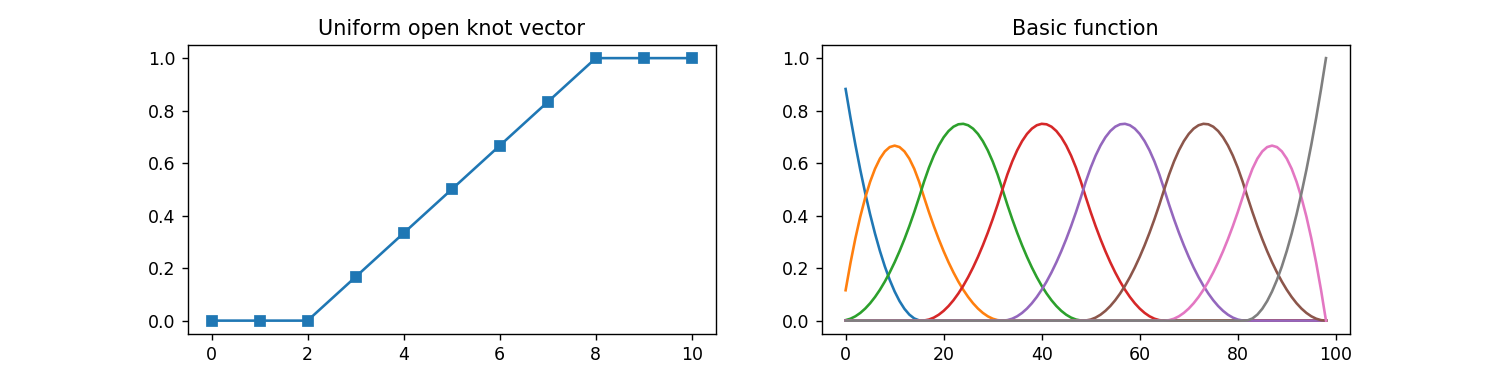

Text(0.5,1,'Basic function')

In [59]:
u = open_uniform_vector(nk, d)
t = np.linspace(0.0, 1, len(x))
fig = plt.figure("knot vector", figsize=(12,3))
plt.subplot(121)
plt.title("Uniform open knot vector")
plt.plot(u, "-s")

plt.subplot(122)
for j in range(n):
    b = []
    for i in range(len(t)):
        if i==0:
            continue
        b.append(basic_function(u, j, d, t[i]))
    plt.plot(b)
plt.xlabel("p")
plt.title("Basic function")

### Optimized control points

In [60]:
# Least Square
P = np.array([x, y]).T # samples
A = np.zeros((m, n)) # Basic function Matrix
for k in range(m):
    for j in range(n):
        A[k, j] = basic_function(u, j, d, t[k])
        
X = np.linalg.inv(A.T.dot(A)).dot(A.T) # X = [A'A]^(-1) A'
Q = X.dot(P) # estimated control points

<IPython.core.display.Javascript object>


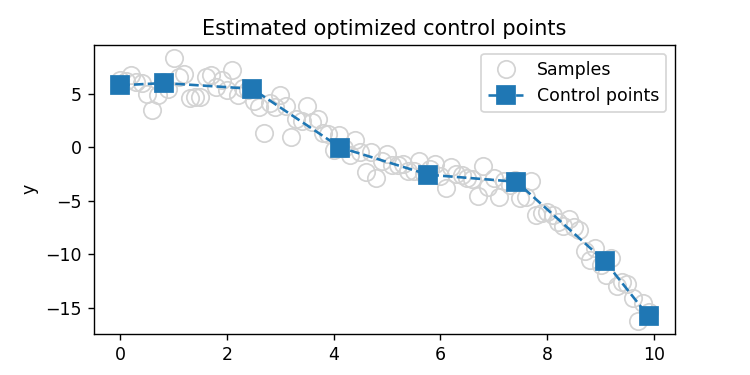

In [61]:
fig = plt.figure("EstimatedContPoints", figsize=(6, 3))
plt.plot(x, y,"o", c="lightgray", mfc="none",  ms=10, label="Samples")
plt.plot(Q[:, 0], Q[:, 1], "s--", ms=10,label="Control points")
plt.title("Estimated optimized control points")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

### Least square B-spline fitting

In [62]:
# B-spline
S = np.zeros((2, len(t)))
Q = Q.T
S[:, 0] = Q[:, 0]
for i in range(len(t)):
    if i==0:
        continue
        
    for j in range(n):
        b = basic_function(u, j, d, t[i] )  
        S[:, i] = S[:, i] + Q[:, j]*b
    # end
# end

<IPython.core.display.Javascript object>


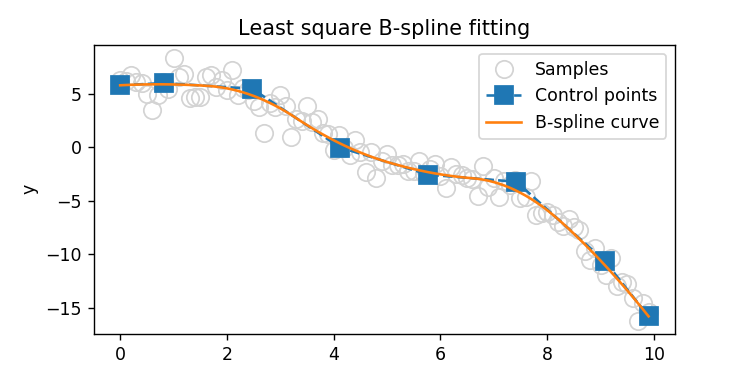

In [63]:
fig = plt.figure("LSBspline", figsize=(6, 3))
plt.plot(x, y,"o", c="lightgray", mfc="none",  ms=10, label="Samples")
plt.plot(Q[0, :], Q[1, :], "s--", ms=10,label="Control points")
plt.plot(S[0, :], S[1, :], "-", label="B-spline curve")

plt.title("Least square B-spline fitting")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

In [ ]:
class L